In [1]:
import os
import pandas as pd
import numpy as np
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from sklearn import preprocessing 

cwd = os.getcwd()
file = '/'.join(cwd.split('/')) + '/WA_Fn-UseC_-Sales-Win-Loss.csv'
data = pd.read_csv(file, index_col = 0)

In [2]:
# Data Preparition
# First change opportunity result(our target variable) to numeric
data_clean = data.copy()
minority = data_clean['Opportunity Result'].value_counts().idxmin()
result = np.array((data_clean['Opportunity Result'] == minority).astype(int))
data_clean = data_clean.drop(['Opportunity Result'], axis = 1)
# For each categorical variables in the dataset, try to assign an unique indicator variable 
#      for each different category
# (This may not be a good step because it adds too many columns, but we'll see)
for col in data_clean.columns:
    if is_string_dtype(data_clean[col]):
        name_set = set(data_clean[col])
        for name in name_set:
            data_clean[' '.join([col, name, 'indicator'])] = (data_clean[col] == name).astype(int)
        data_clean = data_clean.drop([col], axis = 1)
# Check if there is any null value in our dataset
if data_clean.isnull().any().any():
    print('NO!!!!!')
# Gladly, we don't have any

# Normalize our dataset
scale = preprocessing.StandardScaler()
data_clean = pd.DataFrame(scale.fit_transform(data_clean), columns = data_clean.columns)
data_clean['result'] = result

In [3]:
data_clean.describe()

,Elapsed Days In Sales Stage,Sales Stage Change Count,Total Days Identified Through Closing,Total Days Identified Through Qualified,Opportunity Amount USD,Client Size By Revenue,Client Size By Employee Count,Revenue From Client Past Two Years,Ratio Days Identified To Total Days,Ratio Days Validated To Total Days,...,Region Mid-Atlantic indicator,Route To Market Telecoverage indicator,Route To Market Telesales indicator,Route To Market Other indicator,Route To Market Reseller indicator,Route To Market Fields Sales indicator,Competitor Type None indicator,Competitor Type Known indicator,Competitor Type Unknown indicator,result
count,7.802500e+04,7.802500e+04,7.802500e+04,7.802500e+04,7.802500e+04,7.802500e+04,7.802500e+04,7.802500e+04,7.802500e+04,7.802500e+04,...,7.802500e+04,7.802500e+04,7.802500e+04,7.802500e+04,7.802500e+04,7.802500e+04,7.802500e+04,7.802500e+04,7.802500e+04,78025.000000
mean,-3.091560e-14,1.032697e-14,2.873557e-15,-1.546493e-14,3.204324e-16,1.236147e-13,1.052410e-13,5.522483e-15,-8.668781e-15,-3.929955e-16,...,1.759223e-13,-6.044190e-15,2.243096e-14,-1.237262e-14,6.149945e-16,-4.050461e-15,1.848216e-14,-2.199765e-14,2.841542e-15,0.225915
std,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,...,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,0.418186
min,-1.639821e+00,-1.306231e+00,-9.999325e-01,-9.850178e-01,-6.881732e-01,-5.020929e-01,-4.989112e-01,-3.260160e-01,-5.563645e-01,-1.089806e+00,...,-3.277393e-01,-8.942481e-02,-1.830632e-01,-1.949215e-01,-8.962909e-01,-9.560927e-01,-3.668951e-01,-4.272440e-01,-1.631862e+00,0.000000
25%,-9.251439e-01,-6.383324e-01,-7.608337e-01,-7.435082e-01,-5.755269e-01,-5.020929e-01,-4.989112e-01,-3.260160e-01,-5.563645e-01,-1.089806e+00,...,-3.277393e-01,-8.942481e-02,-1.830632e-01,-1.949215e-01,-8.962909e-01,-9.560927e-01,-3.668951e-01,-4.272440e-01,-1.631862e+00,0.000000
50%,-2.239376e-02,2.956645e-02,-2.826361e-01,-2.604891e-01,-3.201953e-01,-5.020929e-01,-4.989112e-01,-3.260160e-01,-5.563645e-01,-8.997158e-02,...,-3.277393e-01,-8.942481e-02,-1.830632e-01,-1.949215e-01,-8.962909e-01,-9.560927e-01,-3.668951e-01,-4.272440e-01,6.127969e-01,0.000000
75%,8.051272e-01,2.956645e-02,4.346603e-01,4.640396e-01,1.010943e-01,-5.020929e-01,-4.989112e-01,-3.260160e-01,-1.599568e-02,1.141967e+00,...,-3.277393e-01,-8.942481e-02,-1.830632e-01,-1.949215e-01,1.115709e+00,1.045924e+00,-3.668951e-01,-4.272440e-01,6.127969e-01,0.000000
max,6.259242e+00,1.338754e+01,1.143321e+01,1.157348e+01,6.821580e+00,2.734707e+00,2.804863e+00,3.973747e+00,2.183495e+00,1.141967e+00,...,3.051206e+00,1.118258e+01,5.462593e+00,5.130271e+00,1.115709e+00,1.045924e+00,2.725575e+00,2.340583e+00,6.127969e-01,1.000000


In [4]:
# Since this is just a trial, split training and test data randomly(Later we could use k-fold cross validation)
length = len(data_clean['result'])
train_index = []
test_index = []
for i in range(length):
    train_index.append(i) if np.random.rand() <= 0.8 else test_index.append(i)
data_train = data_clean.iloc[train_index, :]
data_test = data_clean.iloc[test_index, :]

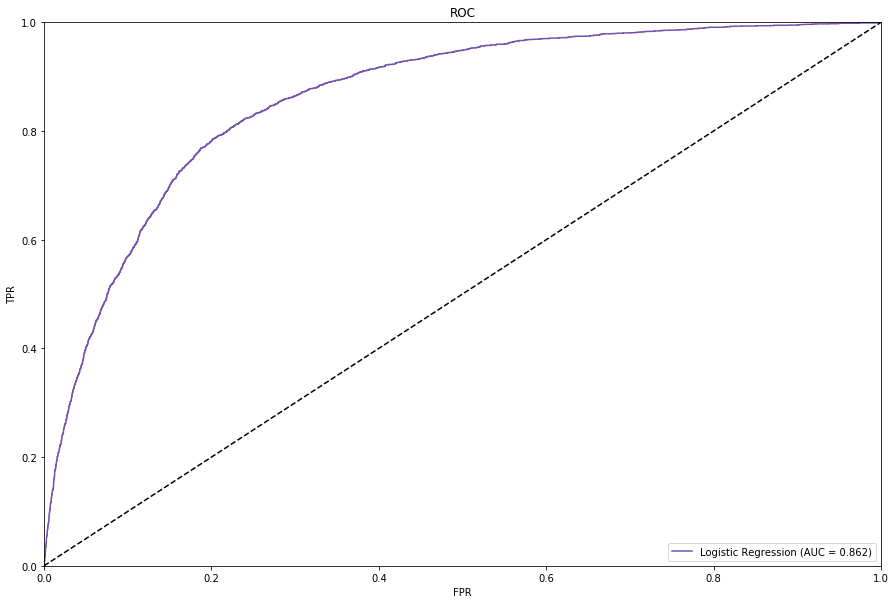

In [5]:
from sklearn import linear_model
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt
%matplotlib inline
# Firstly, run a Logistic Regression
lg = linear_model.LogisticRegression(C = 1e30)
lg.fit(data_train.drop(['result'], axis = 1), data_train['result'])
result_lg = lg.predict_proba(data_test.drop(['result'], axis = 1))[:, 1]

def plotROC(preds, truth, name):
    fpr, tpr, thresholds = roc_curve(truth, preds)
    roc_auc = auc(fpr, tpr)
    # chooses a random color for plotting
    c = (np.random.rand(), np.random.rand(), np.random.rand())
    #create the plot
    plt.plot(fpr, tpr, color = c, label = name + ' (AUC = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')
    plt.legend(loc="lower right")
    
    return roc_auc

# Plot ROC for both models
fig = plt.figure(figsize = (15, 10))
plotROC(result_lg, data_test['result'], 'Logistic Regression')
plt.show()

The above AUC score is quite convincing(to my surprise)...
I think for our problem, since the opportunity amount varies from instance to instance, the profit IBM will get from each instance varies as well. So it's not likely for us to choose a universal threshold for all the instances.

In [6]:
# Do a decision tree and support vector machine and compare them with logistic regression
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
DT = DecisionTreeClassifier(criterion = 'entropy', min_samples_split = 2000, min_samples_leaf = 200)
DT.fit(data_train.drop(['result'], axis = 1), data_train['result'])
result_DT = DT.predict_proba(data_test.drop(['result'], axis = 1))[:, 1]

I don't know why svm runs so slowly so I separate them.

In [ ]:
# svm first
svm = svm.SVC(kernel = "linear")
svm.fit(data_train.drop(['result'], axis = 1), data_train['result'])
result_svm = svm.decision_function(data_test.drop(['result'], axis = 1))
Then DT(I chose parameters randomly)

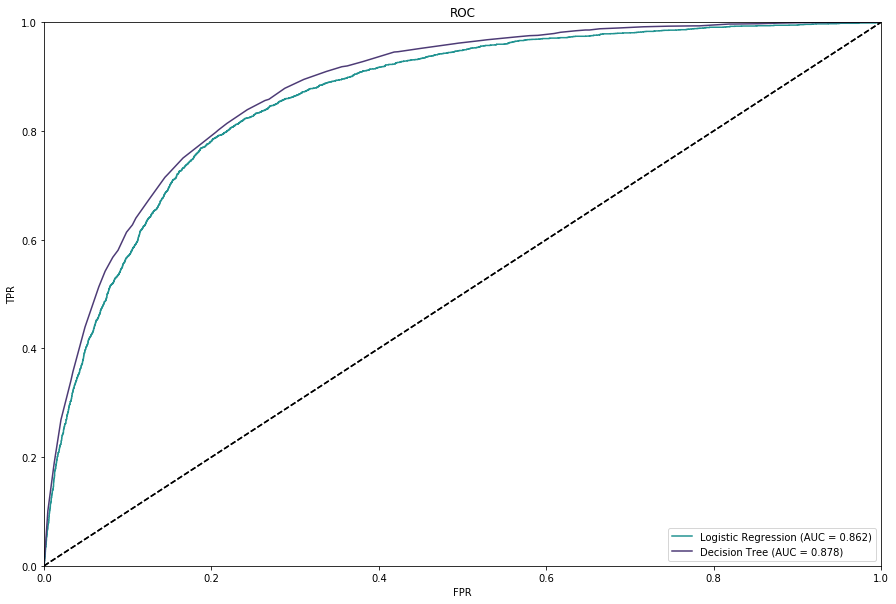

In [8]:
#Plot
fig = plt.figure(figsize = (15, 10))
plotROC(result_lg, data_test['result'], 'Logistic Regression')
#plotROC(result_svm, data_test['result'], 'Support Vector Machine')
plotROC(result_DT, data_test['result'], 'Decision Tree')
plt.show()

In [52]:
# Find feature importances derived by Decision Tree and logistic regression, make it a dataframe
imp = dict(zip(data_clean.columns[0: -1], [[i] for i in DT.feature_importances_]))
feature_imp = pd.DataFrame.from_dict(data = imp, orient = 'index')
feature_imp.columns = ['Decision Tree']
feature_imp['Logistic Regression'] = lg.coef_[0, :]

In [53]:
feature_imp

,Decision Tree,Logistic Regression
Elapsed Days In Sales Stage,0.017333,-0.083626
Sales Stage Change Count,0.100654,0.605810
Total Days Identified Through Closing,0.003232,-0.159975
Total Days Identified Through Qualified,0.316803,-1.208487
Opportunity Amount USD,0.076952,0.354542
Client Size By Revenue,0.000000,0.047687
Client Size By Employee Count,0.000000,0.061577
Revenue From Client Past Two Years,0.209556,0.610908
Ratio Days Identified To Total Days,0.022870,-0.667815
Ratio Days Validated To Total Days,0.010129,-0.458850


It seems like most of the indicator variable doesn't have much influence on the classfication